# Model Selection

Notebook to plot and analyse training results to select best models and corresponding model and dataset hyperparameters  
  
The first selecting criteria are the best cross-epoch results which are the averaged performances of the best models resulting from each folds.  (cell 'Best Epoh > Cross Epochs')  

Other point taken into account in the selection :    
- smoothness of the validation curve (cell 'Validation Curve')   
  (highly volatile validation curves might suggest lucky and less generalisable best results)    
- correlation of the training and validation curve (cells 'Training vs Validation')   
  (when the training and validation compositions is similar the curves   
   should be correlated up to the overfitting point,  
   however it is not the case for different weights and composition between training and validation,  
   in such cases the comparison between both curves is harder to interpret and less valuable)

# Config

In [5]:
COLAB = False

if COLAB : 
  configSetup = {
      'COLAB'           : 'True',
      'PATH_ROOT_DRIVE' : '/content/drive/MyDrive/Projects/Forecast',
      'PATH_ROOT_LOCAL' : '/content/session',
      'PATH_SUNDL'      : '/content/sundl',
      'PATH_PROJECT'    : '/content/flare_limits_pcnn',
  }
  !git clone https://github.com/gfrancisco20/sundl.git
  !git clone https://github.com/gfrancisco20/flare_limits_pcnn.git
  import sys
  import re
  sys.path.append(configSetup['PATH_SUNDL'])
  sys.path.append(configSetup['PATH_PROJECT'])
  configFile = f'{configSetup["PATH_PROJECT"]}/config.py'
  with open(configFile, 'r') as file:
    content = file.read()
  for constant in configSetup.keys():
    content = re.sub(re.compile(f'{constant} = .*'), f'{constant} = \'{configSetup[constant]}\'', content)
  with open(configFile, 'w') as file:
    file.write(content)
   
from config import *
if COLAB:
  from sundl.utils.colab import mountDrive
  # mouting drive content in session on colab
  mountDrive()

# FOR GIT EXAMPLE ONLY
from pathlib import Path
PATH_RES = Path('.')

# Libraries

In [11]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from ipywidgets import interact
from glob import glob

# Setup

In [12]:
FOLDER = PATH_RES/'Results'  # Results (final resluts ); Results_Old_Dataset (previous hyperparameter search)
 
# from pathlib import Path
# FOLDER = Path('./flare_limits_pcnn/Results_Paper_PCNN')

sortingMtc = 'val_tss'

epochLim = None

plotByNumInst = False # --> to compare models trained on sets of different sizes
if plotByNumInst:
  xaxisID = 'num_train_inst'
else:
  xaxisID = 'epoch'

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12,8)

# Load CV Results

In [13]:
best = pd.read_csv(FOLDER/'bests.csv').sort_values(by=[sortingMtc],ascending=False)
bestCvCrEpcPath = FOLDER/'bestsCVCrossEpoch.csv'
HAS_CV = False
bestCVCrossEpoch =  None
if bestCvCrEpcPath.exists():
  bestCVCrossEpoch = pd.read_csv(bestCvCrEpcPath).sort_values(by=[sortingMtc],ascending=False)
  HAS_CV = True

list_metrics = [col for col in list(best.columns) if (col != 'model' and col[0:2]!='va' and col[-2:] not in ['pc','td','in','ax','st'])]
list_metrics_vals = [f'val_{col}' for col in list_metrics]

models = list(best['model'])

res = {}
resFolds = {}
for model in models:
  if epochLim is not None:
    res[model] =  pd.read_csv((FOLDER/f'training_{model}.csv').as_posix()).loc[0:epochLim]
  else:
    res[model] =  pd.read_csv((FOLDER/f'training_{model}.csv').as_posix())
  resFolds[model] = {}
  for idxFold, foldTrainingPath in enumerate(glob((FOLDER/f'training_folds/training_{model}*.csv').as_posix())):
    resFolds[model][idxFold] = pd.read_csv(foldTrainingPath)
  
# normalisation of the xaxis for model with different number of trained instances
if plotByNumInst:
  # axis calculation
  xaxis = []
  for model in models:
    xaxis = xaxis + list(res[model][xaxisID].values)
  xaxis = sorted(set(xaxis))
  # rows insertions
  complementaryRows = {num_inst : dict(**{col : np.nan for col in res[models[0]].columns if col != xaxisID}, **{xaxisID:num_inst}) for num_inst in xaxis}
  for model in models:
    for num_inst in xaxis:
      if num_inst not in res[model][xaxisID].values:
        res[model] = res[model].append(complementaryRows[num_inst], ignore_index=True)
    res[model].sort_values(by=[xaxisID], ascending=True, inplace=True, ignore_index=True)
    res[model].set_index(xaxisID ,inplace=True)

  # Interpolation
    res[model].interpolate(method='index', axis=0, limit_direction='forward', inplace = True)
    res[model]['epoch'] = res[model]['epoch'].fillna(np.max(res[model]['epoch'].fillna(-1))) # useless?
    res[model].reset_index(inplace=True)
    res[model][xaxisID] = res[model][xaxisID].astype('int64')
    res[model] = res[model].set_index(xaxisID)

# Result dataframes

In [14]:
viz_metrics = [
 'val_acc',
 'val_tss',
 'val_hss',
 'val_mcc',
 'val_f1',
 'val_recall',
 'val_precision',
 'val_auc_roc',
 'val_auc_pr',
 'val_far',
 'val_TP',
 'val_FN',
 'val_TN',
 'val_FP',
 'val_loss']

Model names structure is as followed :  
**{cls}\_{labelCol}\_{Archi}\_{Pretraining}\_{WeightStrategy}\_{Optimizer}\_{Input}\_{windowSize_h}**  

With : 
- **cls**         : the binary class threshold, e.g. 'C+'  
- **labelCol**    : the columns on which the classes are defined, e.g. 'mpf' or 'toteh' (fluence)  
- **Archi**       : model architecture, ex: 'PTx8' for a PCNN of 8 patches, 'FD' for a full-disk CNN (here an EffNetV2S)  
- **Pretraining** :   
  'FlTr'  -> no pretrained weight (random initial weight) ;  
  'Ptrd'  -> pretrained without retraining ;       
  'RtdXz' -> pretrained  and retrained for the last z layers (excluding batchnorm layers) 
- **WeightStrategy** : name of the weight strategy used on the training to penalise differently sub-cases of positiive and negative events
- **Optimizer**    : e.g. 'AW1e5D1e4' -> AdamW, lr 1e-5, weight_decay 1e-4
- **Input**        : e.g. 'blos','0193x0211x0094'
- **windowSize_h** : size of the time-windows on which aree compted the labels (in hours)

In [15]:
display(bestCVCrossEpoch[['model','val_tss_epcs','val_tss_min','val_tss_max','val_tss_std']+viz_metrics])#[:10])

,model,val_tss_epcs,val_tss_min,val_tss_max,val_tss_std,val_acc,val_tss,val_hss,val_mcc,val_f1,val_recall,val_precision,val_auc_roc,val_auc_pr,val_far,val_TP,val_FN,val_TN,val_FP,val_loss
0,C+_mpf_Persistent_24,0x0x0x0x0,0.557194,0.772773,0.080574,0.852254,0.702772,0.703008,0.703523,0.862034,0.864850,0.859807,0.852254,0.821265,0.140193,920.2,143.8,783.6,151.6,2.265988
15,C+_mpf_jpgxhRes_PTx8_RtdXall_EquiC_AW1e5D1e4_0...,4x4x4x7x6,0.469847,0.823359,0.122229,0.848992,0.694840,0.695578,0.700301,0.865018,0.960039,0.893874,0.911371,0.905312,0.106126,994.0,275.4,824.2,648.8,0.389334
14,C+_mpf_pngxhRes_PTx8_RtdXall_EquiC_AW1e5D1e4_0...,2x3x5x11x13,0.478351,0.803669,0.112846,0.846801,0.690707,0.691661,0.696007,0.862949,0.969774,0.896587,0.911759,0.906957,0.103413,1004.0,259.0,813.8,720.6,0.407288
13,C+_mpf_jpg_PTx8_RtdXall_EquiC_AW1e5D1e4_0193x0...,5x6x6x7x2,0.472109,0.804134,0.115235,0.846398,0.686999,0.689559,0.693317,0.862564,0.998844,0.918345,0.910809,0.906361,0.081655,1034.2,435.6,865.2,907.4,0.403881
6,C+_mpf_png_PTx8_RtdXall_ProgPos_AW1e5D1e4_0193...,5x5x5x8x5,0.457910,0.814871,0.118413,0.840674,0.674273,0.677768,0.684917,0.859950,1.000000,0.845320,0.895131,0.887867,0.154680,1035.4,168.4,743.6,913.8,0.453646
4,C+_mpf_jpg_PTx8_RtdXall_ProgPos_AW1e5D1e4_0193...,6x12x8x12x6,0.453849,0.795956,0.118647,0.838311,0.673002,0.673391,0.679845,0.857875,0.998459,0.852359,0.890690,0.880835,0.147641,1033.8,193.4,756.4,901.8,0.456802
5,C+_mpf_jpg_PTx8_RtdXall_ProgPos_AW1e5D1e4_blos_24,8x6x7x9x8,0.481073,0.761462,0.093614,0.820473,0.636878,0.637969,0.640796,0.839053,0.999810,0.852222,0.885996,0.878196,0.147778,1045.6,250.4,765.4,898.4,0.462152
8,C+_mpf_jpg_PTx8_RtdXall_ProgPos_AW4e6D4e3_blos_24,13x9x12x12x14,0.504538,0.749889,0.080828,0.817111,0.626931,0.630114,0.635107,0.836997,0.998851,0.822087,0.869666,0.861406,0.177913,1044.6,186.8,713.6,910.0,0.502798
10,C+_mpf_jpg_PTx8_RtdXall_EquiC_AW1e5D1e4_blos_24,6x12x3x10x2,0.484203,0.715698,0.079874,0.807965,0.621755,0.617055,0.622383,0.819746,0.935936,0.935145,0.882550,0.875670,0.064855,978.4,601.0,868.0,647.0,0.471104
11,M+_mpf_jpg_PTx8_RtdXall_LowC2_AW1e5D1e4_0193x0...,5x4x6x3x3,0.477306,0.617766,0.053348,0.841113,0.569513,0.416292,0.444000,0.529812,0.998675,0.483262,0.875078,0.819701,0.516738,303.0,188.6,1523.8,1562.2,0.509099


# Best Epoch - Comparisons

The actual model selection must be made on cross-epoch CV results, as our final models are the ensembles of the models of each fold selected at their best epoch.

M+_mpf_jpg_PTx8_RtdXall_LowC2_AW1e5D1e4_0193x0211x0094_24 val_tss True 0
M+_mpf_jpg_PTx8_RtdXall_EquiM_AW1e5D1e4_0193x0211x0094_24 val_tss True 0
M+_mpf_png_PTx8_RtdXall_LowC2_AW1e5D1e4_0193x0211x0094_24 val_tss True 0
M+_mpf_jpg_PTx8_RtdXall_LowC2_AW6e6D1e3_blos_24 val_tss True 0
M+_mpf_jpg_PTx8_RtdXall_LowC2_AW1e5D1e4_blos_24 val_tss True 0
M+_mpf_jpg_PTx8_RtdXall_EquiM_AW1e5D1e4_blos_24 val_tss True 0
M+_mpf_jpg_PTx8_RtdXall_LowC2_AW1e5D1e4_0193x0211x0094_24 val_hss False 1
M+_mpf_jpg_PTx8_RtdXall_EquiM_AW1e5D1e4_0193x0211x0094_24 val_hss False 1
M+_mpf_png_PTx8_RtdXall_LowC2_AW1e5D1e4_0193x0211x0094_24 val_hss False 1
M+_mpf_jpg_PTx8_RtdXall_LowC2_AW6e6D1e3_blos_24 val_hss False 1
M+_mpf_jpg_PTx8_RtdXall_LowC2_AW1e5D1e4_blos_24 val_hss False 1
M+_mpf_jpg_PTx8_RtdXall_EquiM_AW1e5D1e4_blos_24 val_hss False 1
M+_mpf_jpg_PTx8_RtdXall_LowC2_AW1e5D1e4_0193x0211x0094_24 val_mcc False 2
M+_mpf_jpg_PTx8_RtdXall_EquiM_AW1e5D1e4_0193x0211x0094_24 val_mcc False 2
M+_mpf_png_PTx8_RtdXall_LowC2_

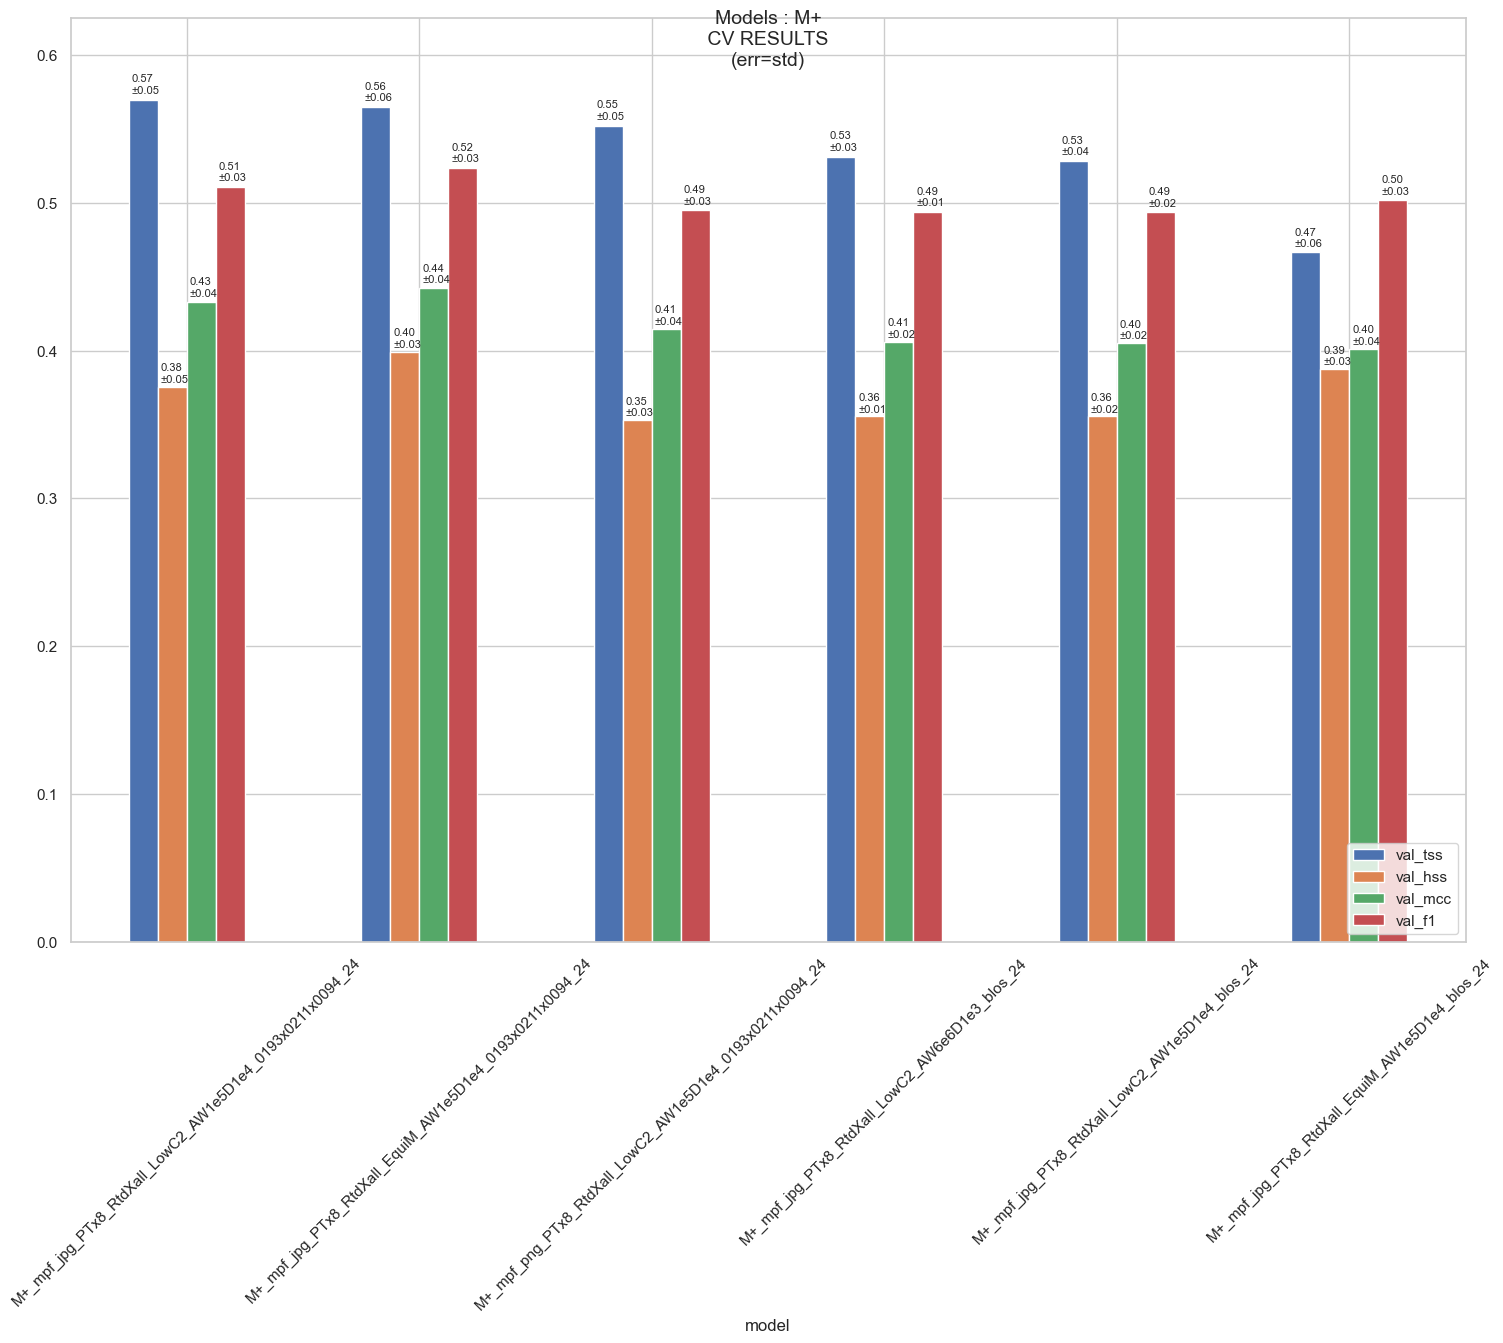

In [17]:
types    = ['M+']
hasCV    = True
metrics  = ['val_tss','val_hss', 'val_mcc', 'val_f1'] # ['val_tss','val_far']
pltBest  = [True     , False   ,  False   ,  False]
# pltBest  = [True     , True   ,  True   ,  True]
err_type = 'std' # 'std' , 'minmax'
kind     = "bar"
num_top  = 6
archis   = f'{types[0]}'



tmp = bestCVCrossEpoch.copy()

tmp['type'] = tmp['model'].apply(lambda x: x[:2])
tmp = tmp[tmp['type'].isin(types)]
if num_top is None: num_top = len(tmp)
tmp = tmp[0:num_top]
sub_models = tmp['model'].values

if not hasCV:
  print('No CV')
else:
  if type(num_top)==str: num_top = len(best)
  tmp = tmp.sort_values(by=[metrics[0]], ascending = False).set_index('model')
  models = list(tmp.index)

  if err_type == 'minmax': err_type = ('min','max')
  if type(err_type) in [tuple,list]:
    yerr=[[tmp[metrics[i]+'_'+err_type[0]]-tmp[metrics[i]],tmp[metrics[i]+'_'+err_type[1]]-tmp[metrics[i]]] for i in range(len(metrics))]
    yerr = np.abs(yerr)
  else:
    yerr=[tmp[metrics[i]+'_'+err_type]  for i in range(len(metrics))]
  ax = tmp[metrics].\
        plot(kind=kind,figsize=(18, 12))#,yerr=yerr)
  refEpochs = {}
  refEpoch = {}
  for idx,p in enumerate(ax.patches):
    #print(f'{idx: >2} : {p.get_height():.2f}')
    mtcIdx = idx // len(sub_models)
    modIdx = idx % len(sub_models)
    
    
    print(sub_models[modIdx], metrics[mtcIdx], pltBest[mtcIdx], mtcIdx)
    
    # mtcIdx = idx // len(metrics)
    # modIdx = idx % len(sub_models)
    
    # modIdx = idx // len(sub_models)
    # mtcIdx = idx % len(sub_models)
    
    takeBest = pltBest[mtcIdx]
    
    if takeBest:
    #   # else -> take epoch of the reference metric
    #   if metrics[mtcIdx][-3:] in ['loss','far','mae','mse','rmse','maep']:
    #     epoch = np.argmin(res[sub_models[modIdx]][metrics[mtcIdx]])
    #   else:
    #     epoch = np.argmax(res[sub_models[modIdx]][metrics[mtcIdx]])
    #   refEpochs[sub_models[modIdx]] = epoch
    # else:
    #   epoch = refEpochs[sub_models[modIdx]]
    
      epoch = tmp.loc[sub_models[modIdx]][metrics[mtcIdx]+'_epcs']
      epochs = [int(float(e)) for e in epoch.split('x')]
      epoch = f'{np.round(np.mean(epochs)):.0f} \n± {np.round(np.std(epochs)):.0f}'
      
      refEpochs[sub_models[modIdx]] = epochs
      refEpoch[sub_models[modIdx]] = epoch
      
    epochs = refEpochs[sub_models[modIdx]]
    epoch = refEpoch[sub_models[modIdx]] 
    
    if not takeBest:
      foldRes = resFolds[sub_models[modIdx]].copy()
      values = np.zeros(len(epochs))
      for idxFold, e in enumerate(epochs):
        values[idxFold] = foldRes[idxFold].loc[e,metrics[mtcIdx]]
        
      p.set_height(np.mean(values))
      if type(err_type) in [tuple,list]:
        low = np.min(values)
        up  = np.max(values)
        errstr = f'\n<{low:.2f};\n   {up:.2f}>'
      else:
        std = np.std(values)
        errstr = f'\n±{std:.2f}'
    
    else:
      if type(err_type) in [tuple,list]:
        low = tmp.loc[sub_models[modIdx]][metrics[mtcIdx]+'_'+err_type[0]]
        up  = tmp.loc[sub_models[modIdx]][metrics[mtcIdx]+'_'+err_type[1]]
        errstr = f'\n<{low:.2f};\n   {up:.2f}>'
      else:
        std = tmp.loc[sub_models[modIdx]][metrics[mtcIdx]+'_'+err_type]
        errstr = f'\n±{std:.2f}'
    if kind == "barh":
      ax.annotate(f'{p.get_width():.2f} ({epoch})', (p.get_width() * 1.005, p.get_y() + p.get_height()/4))
    elif kind == "bar":
      # if mtcIdx == 0:
      #   ax.annotate(f'{p.get_height():.2f}{errstr}\n(e{epoch:0>2})', (p.get_x() + p.get_width()*0.88, p.get_height() * 1.008), fontsize=10)
      # else:
      ax.annotate(f'{p.get_height():.2f}{errstr}', (p.get_x() + p.get_width()*0.1, p.get_height() * 1.008), fontsize=8)
      #ax.annotate(f'{p.get_height():.2f}\n({epoch})', (p.get_x() * 1.005 - 0.005* (p.get_x() / base - 1), p.get_height() * 1.008), fontsize=12)
  ax.set_ylim((ax.get_ylim()[0],ax.get_ylim()[1]*1.045))
  tmp = tmp.reset_index()
  plt.xticks(rotation=45)
  ypos = 0.94 if hasCV else 0.96
  plt.title(f'Models : {archis}\n CV RESULTS \n(err={str(err_type)})', y = ypos, fontsize=14) # val_tss_epcs val_tss_epcs
plt.legend(loc='lower right')

# Validation Curves - Comparison


Text(0.5, 0.94, 'Model : PCNN - FD -  Peristent\n(err=std)')

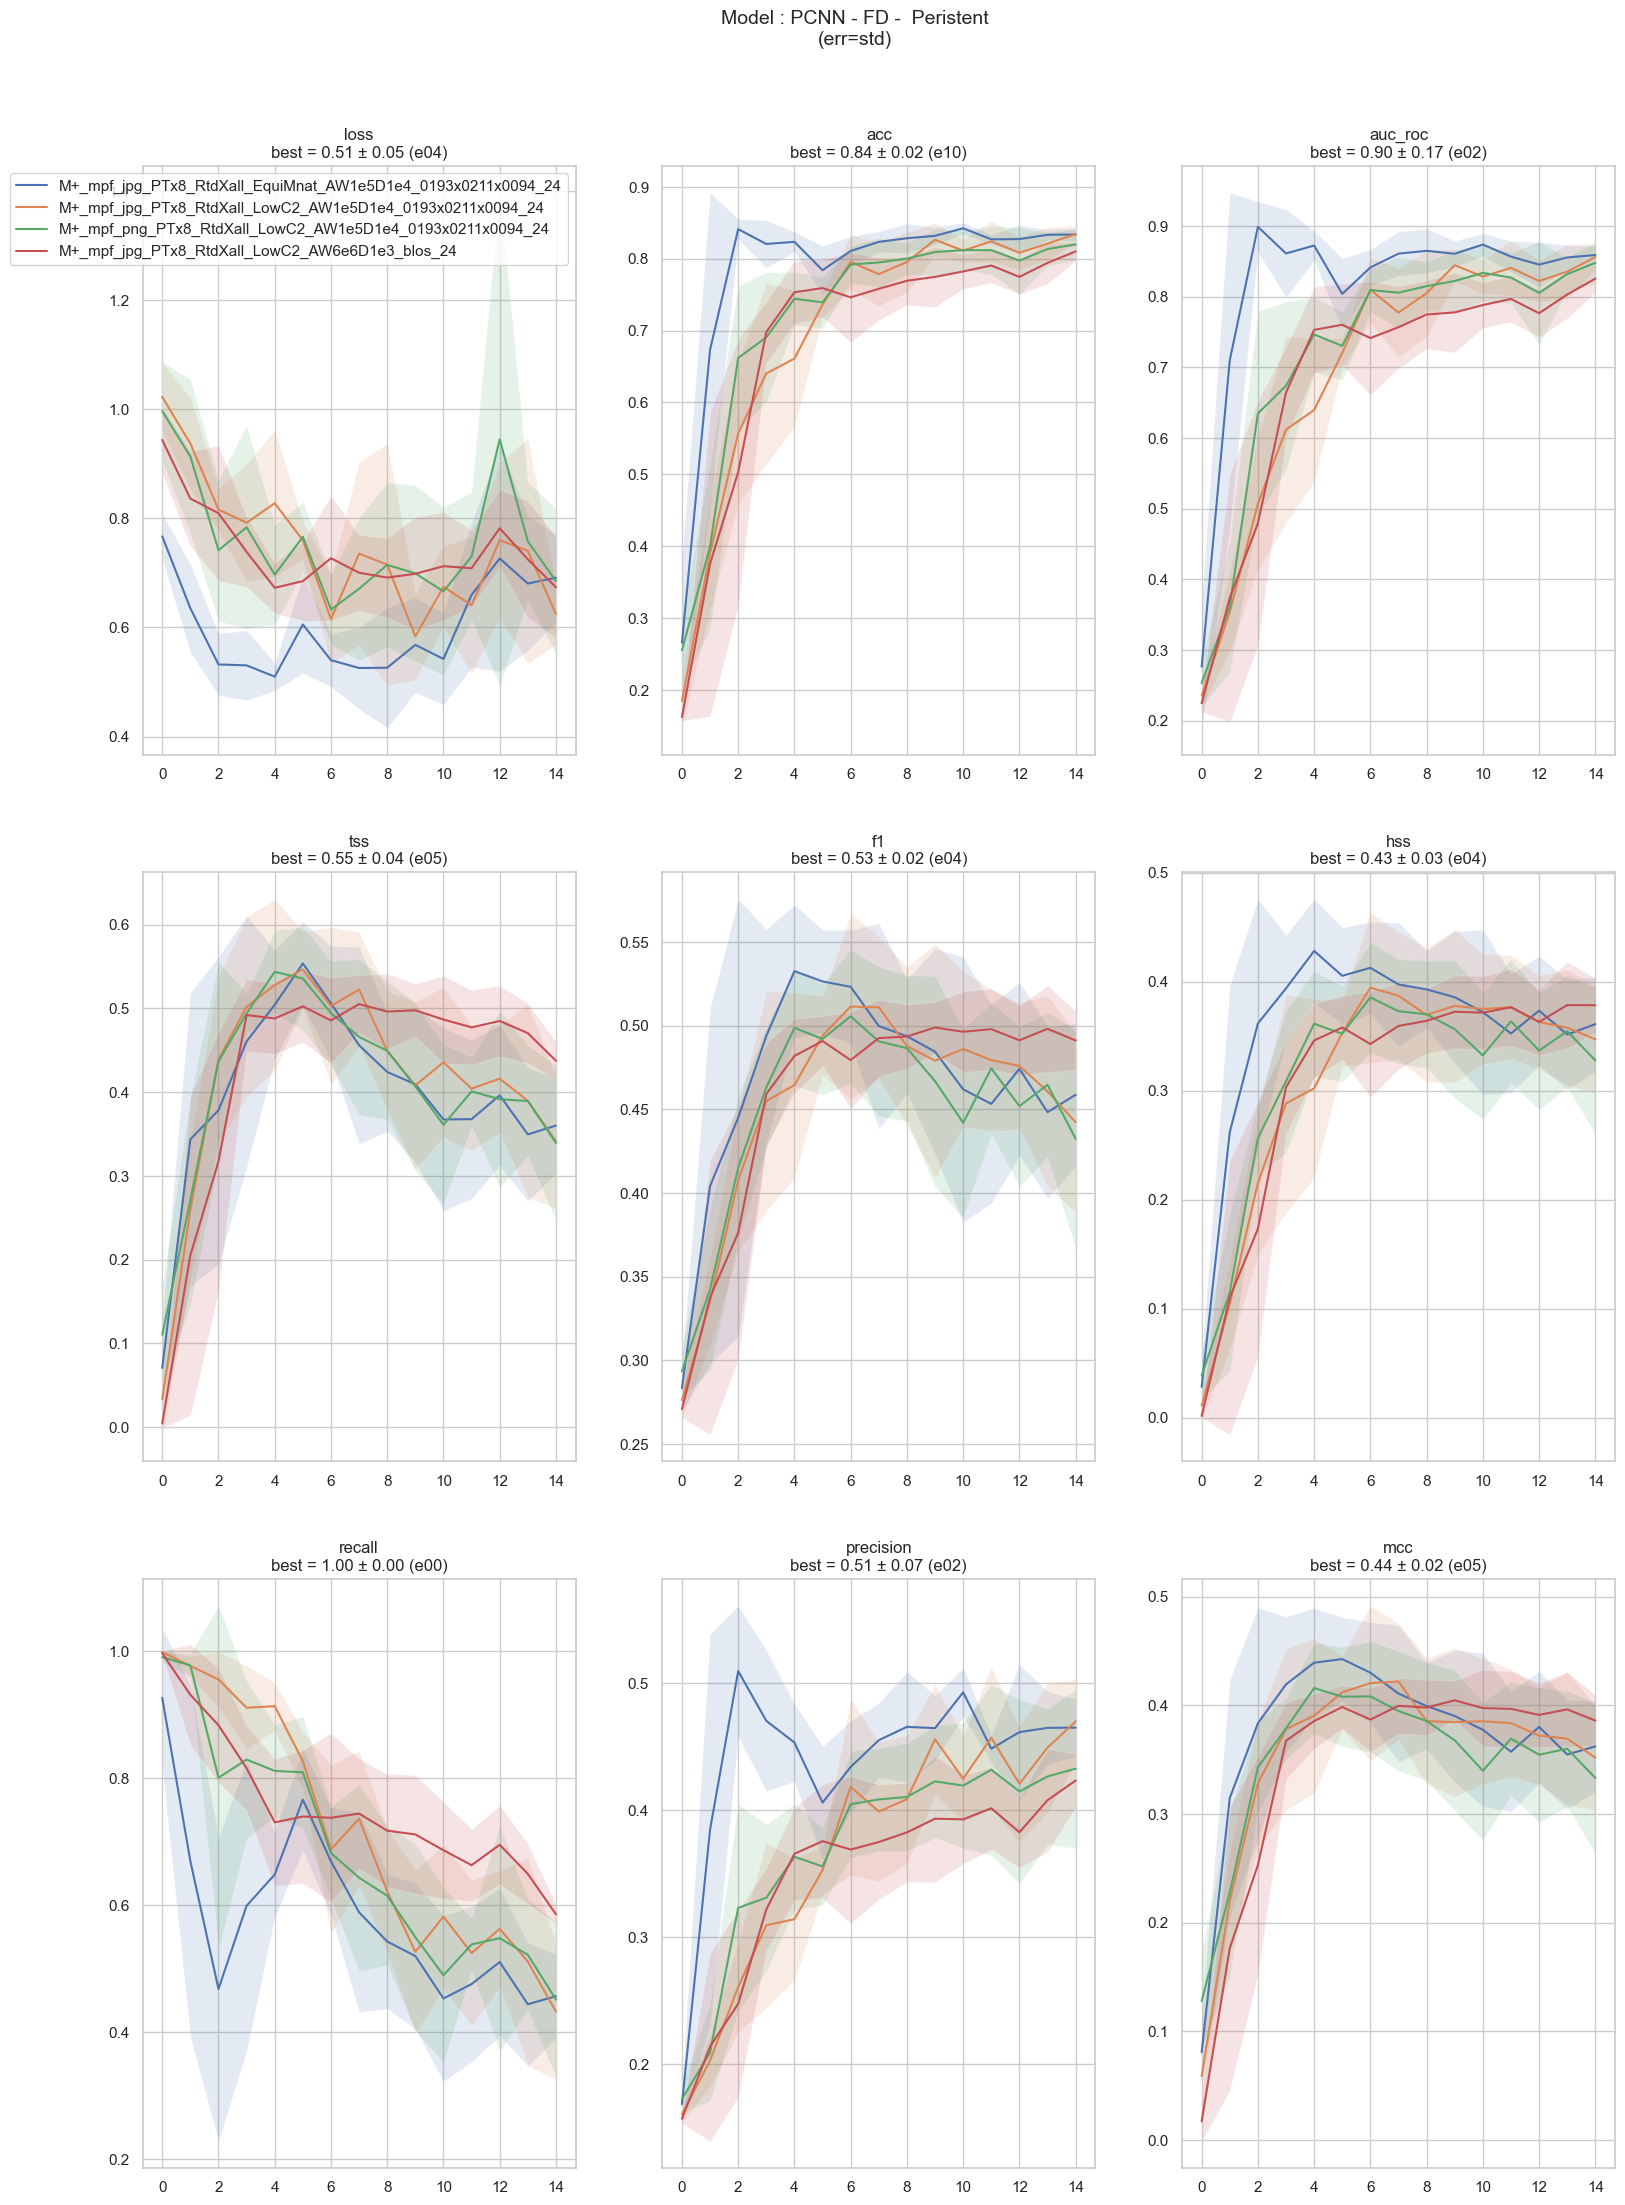

In [11]:
types    = ['M+']
hasCV    = True
num_top  = 4
err_type = 'std' # # 'std' , 'minmax' (used for cv only)
alpherr  = 0.15
archis   = 'PCNN - FD -  Peristent'

metrics = ['loss'  ,'acc','auc_roc',
           'tss'   ,'f1' ,'hss',
           'recall','precision','mcc'
           ]

plt.figure(figsize=(19, 26))

num_metrics = len(metrics)
bestmtc = {}
bestepc = {}
for i in range(num_metrics):
  mtc = metrics[i]
  sub_models = [m for m in models if m[:2] in types]
  if num_top is None:
    num_top = len(sub_models)
  else:
    if num_top <= 0:
      num_top = len(sub_models)
  for idx,model in enumerate(sub_models[0:num_top]):
    if idx==0:
      #ax = plt.subplot(int(np.ceil(np.sqrt(num_metrics))), int(np.round(np.sqrt(num_metrics))), i + 1)
      # ax = plt.subplot(int(np.ceil(np.sqrt(num_metrics)))-1, int(np.round(np.sqrt(num_metrics)))+1, i + 1)
      ax = plt.subplot(int(len(metrics)//3), 3, i + 1)
      #ax = plt.subplot(int(np.round(np.sqrt(num_metrics))), int(np.ceil(np.sqrt(num_metrics))), i + 1)
    val = np.array(res[model]['val_'+mtc])
    if len(val[~np.isnan(val)])==0:
      print(f'WARNING : no data for {model} {metrics[i]}')
    else:
      ax.plot(res[model].index, val, label = model)
      if hasCV:
        if err_type == 'minmax': err_type = ('min','max')
        if type(err_type) in [tuple,list]:
          lower = np.array(res[model]['val_'+mtc+'_'+err_type[0]])
          upper = np.array(res[model]['val_'+mtc+'_'+err_type[1]])
          #lower = lower[~np.isnan(lower)]
          #upper = upper[~np.isnan(upper)]
        else:
          #yerr=best[metrics[0]+'_'+err_type], best[metrics[1]+'_'+err_type]
          err = np.array(res[model]['val_'+mtc+'_'+err_type])
          #err = err[~np.isnan(err)]
          lower = val - err
          upper = val + err
        ax.fill_between(
          range(len(val)),
          lower,
          upper,
          alpha=alpherr)
      val = val[~np.isnan(val)]
      if mtc in ['loss','far','mae','mse']:
        if idx==0:
          bestmtc[mtc] = np.min(val)
          bestepc[mtc] = np.argmin(val)
        else:
          if  np.min(val) < bestmtc[mtc]:
            bestmtc[mtc] = np.min(val)
            bestepc[mtc] = np.argmin(val)
        #if idx==num_metrics-1:
        ax.set_title(f'{mtc}\nbest = {bestmtc[mtc]:.2f} at epoch  {bestepc[mtc]}')
      else:
        if idx==0:
          bestmtc[mtc] = np.max(val)
          bestepc[mtc] = np.argmax(val)
        else:
          if  np.max(val) > bestmtc[mtc]:
            bestmtc[mtc] = np.max(val)
            bestepc[mtc] = np.argmax(val)
        #if idx==num_metrics-1:
      if hasCV:
        if err_type == 'minmax': err_type = ('min','max')
        if type(err_type) in [tuple,list]:
          low = res[model]['val_'+mtc+'_'+err_type[0]][bestepc[mtc]]
          up  = res[model]['val_'+mtc+'_'+err_type[1]][bestepc[mtc]]
          extratitle = f' <{low:.2f};{up:.2f}>'
        else:
          std = res[model]['val_'+mtc+'_'+err_type][bestepc[mtc]]
          extratitle = f' ± {std:.2f}'
        extratitle += f' (e{bestepc[mtc]:0>2})'
      else:
        extratitle = f' at epoch  {bestepc[mtc]}'
      ax.set_title(f'{mtc}\nbest = {bestmtc[mtc]:.2f}{extratitle}')
      if i==0:
        ax.legend()
      #plt.axis("off")
extratitle = f'\n(err={str(err_type)})' if hasCV else ''
plt.suptitle(f'Model : {archis}{extratitle}', y = 0.94, fontsize=14)
# plt.suptitle(f'Model : TOTE-regression 24h', y = 0.94, fontsize=14)

# Training Vs Validation Curves

## Model Comparisons

Due to the different compositions between training and validation as well as the penalisation strategies used during training,  
the M+ models exhibits signifiant differences between the training and validation curves patterns.  
The training evaluation take into account the different weights given to the different sub-classes.  
The performance on each sub-class thus do not contribute equally in the training and the validation evaluation,  
resulting in a correlation between the curves less obvious and harder to interpret.  
It is however a natural reslult of using specific composition and penalisation strategies during training,  
while the final evaluation must be evaluated on a set representative of the general case without weights.  
  
The C+ models are not affected as the problem is balanced and the weights/penalisations used do not generate differences,  
between training and evaluation as marked as for the M+ models

Text(0.5, 0.94, 'Train-Val Comparisons\n(err=std)')

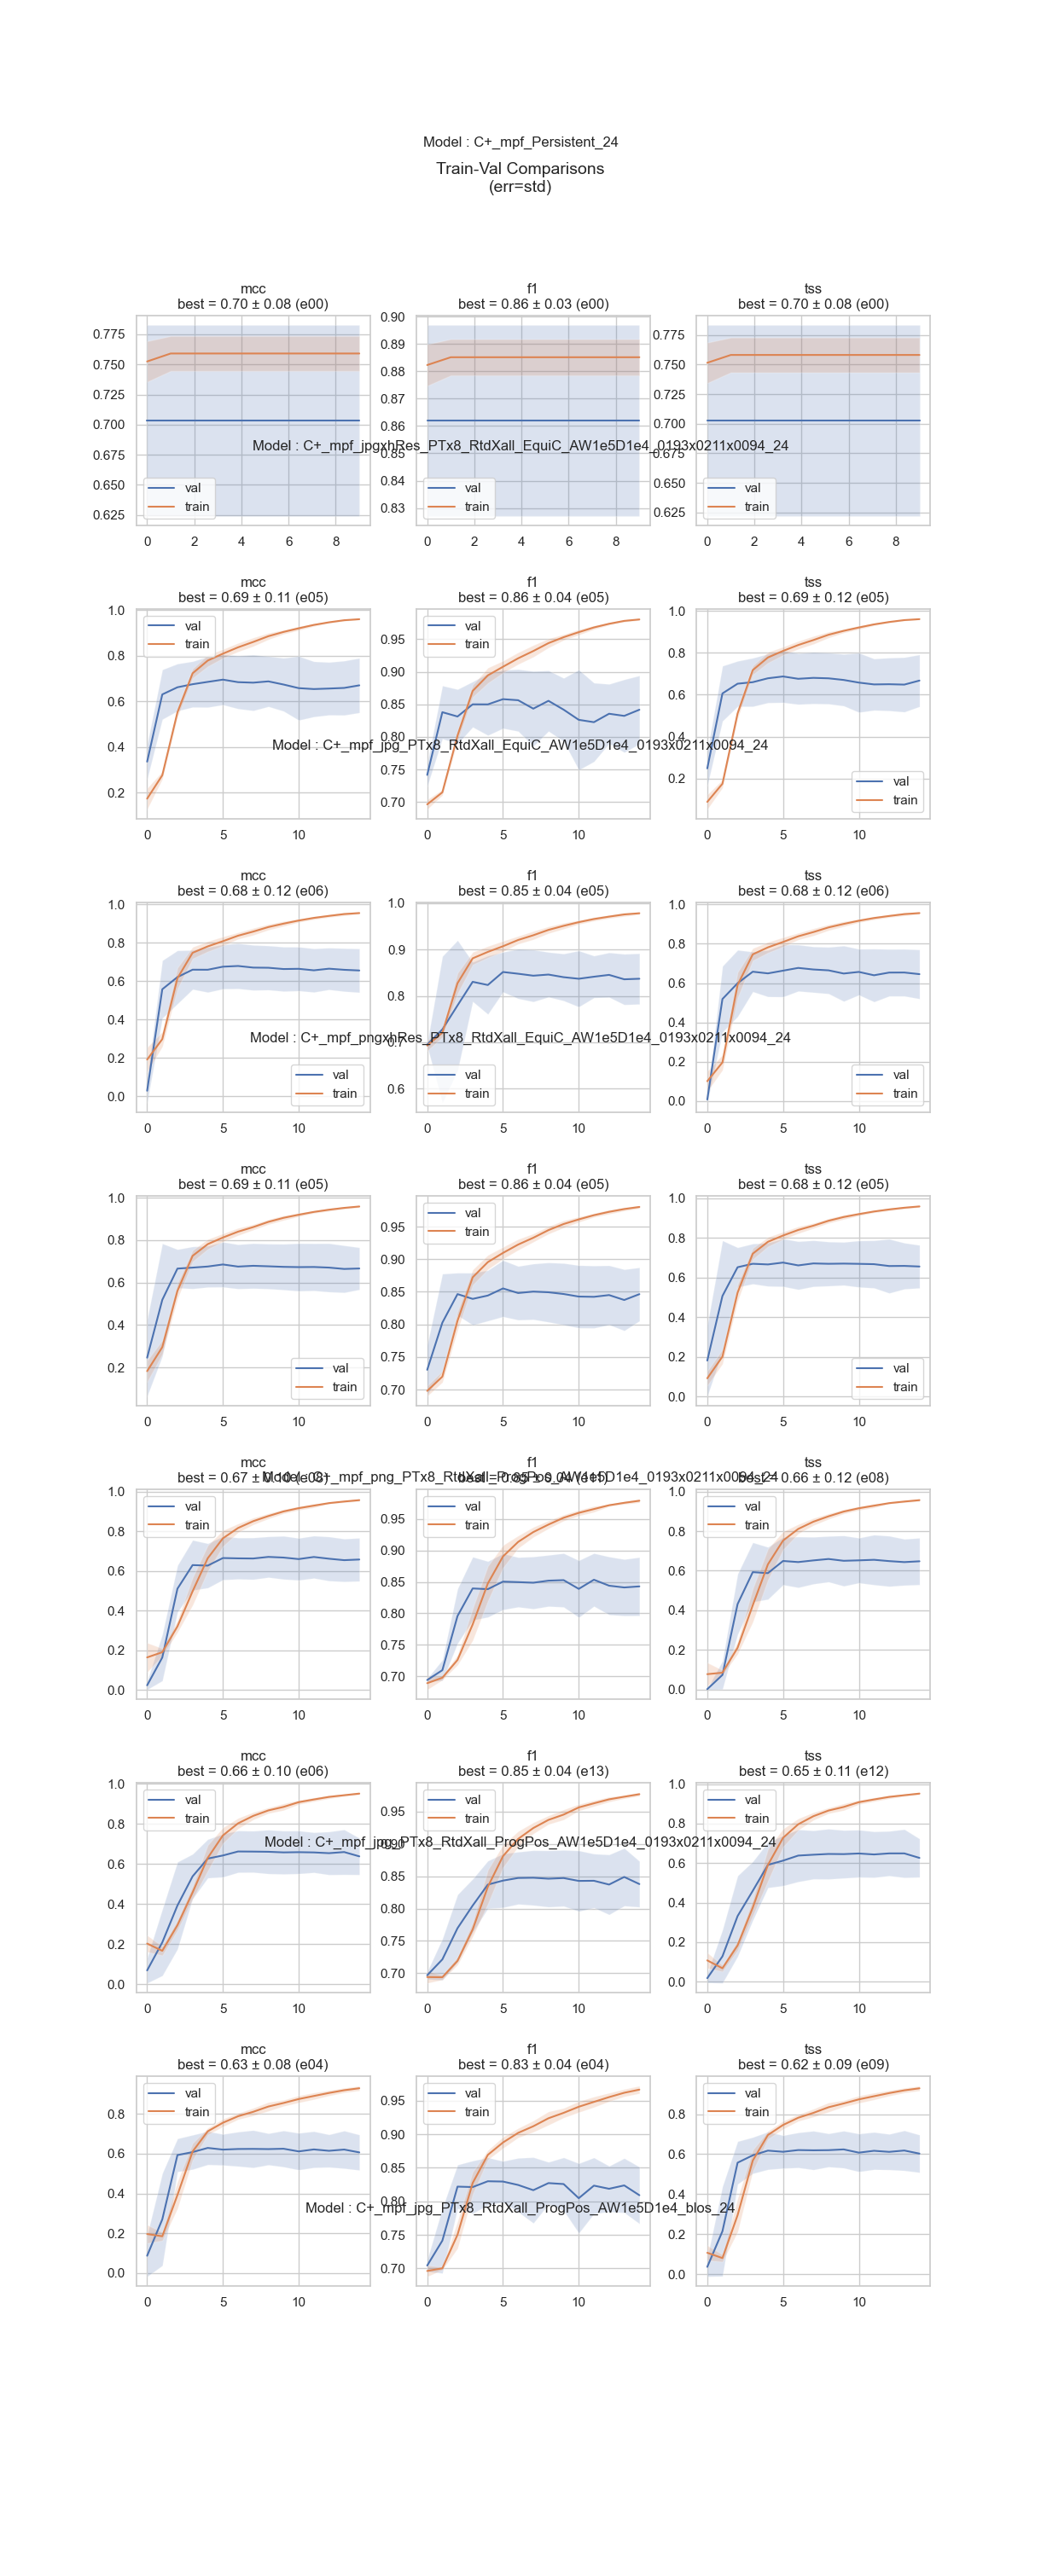

In [16]:
types    = ['C+']
hasCV    = True
num_top  = 7
alpherr  = 0.15
archis   = 'PCNN - FD -  Peristent'

err_type =  'std'# err_type # 'std' , 'minmax' (used for cv only)

plt.rcParams['figure.figsize'] = [12, 30]


metrics = ['mcc','f1', 'tss']
  
tmp = best.copy()
if num_top is None: num_top = len(tmp)

sub_models = [m for m in tmp['model'].values if m[:2] in types]
sub_models = sub_models[0:num_top]


num_metrics = len(metrics)

fig, axs = plt.subplots(nrows=num_top, ncols=num_metrics, constrained_layout=False,
                         gridspec_kw={'wspace': 0.2, 'hspace': 0.4})
# fig(figsize=(15, 30))
gridspec = axs[0,0].get_subplotspec().get_gridspec()
subfigs = [fig.add_subfigure(gs) for gs in gridspec]

for j,model in enumerate(sub_models):
  for i in range(num_metrics):
    mtc = metrics[i]
    ax = axs[j,i]
    val = np.array(res[model]['val_'+mtc])
    if len(val[~np.isnan(val)])==0:
      print(f'WARNING : no data for {model} {metrics[i]}')
    else:
      train = np.array(res[model][mtc])
      for idx,curve in enumerate([val, train]):
        preffix = 'val_' if idx==0 else ''
        label   = 'val' if idx==0 else 'train'
        ax.plot(curve, label=label)
        if hasCV:
          if err_type == 'minmax': err_type = ('min','max')
          if type(err_type) in [tuple,list]:
            lower = np.array(res[model][preffix+mtc+'_'+err_type[0]])
            upper = np.array(res[model][preffix+mtc+'_'+err_type[1]])
            #lower = lower[~np.isnan(lower)]
            #upper = upper[~np.isnan(upper)]
          else:
            yerr=tmp[metrics[0]+'_'+err_type], tmp[metrics[1]+'_'+err_type]
            err = np.array(res[model][preffix+mtc+'_'+err_type])
            #err = err[~np.isnan(err)]
            lower = curve - err
            upper = curve + err
          ax.fill_between(
            range(len(curve)),
            lower,
            upper,
            alpha=0.2)
      val = val[~np.isnan(val)]
      if mtc in ['loss','far','mae','mse']:
        bestmtc = np.min(val)
        bestepc = int(np.argmin(val))
      else:
        bestmtc = np.max(val)
        bestepc = int(np.argmax(val))
      if hasCV:
        if err_type == 'minmax': err_type = ('min','max')
        if type(err_type) in [tuple,list]:
          low = res[model]['val_'+mtc+'_'+err_type[0]][bestepc]
          up  = res[model]['val_'+mtc+'_'+err_type[1]][bestepc]
          extratitle = f' <{low:.2f};{up:.2f}>'
        else:
          std = res[model]['val_'+mtc+'_'+err_type][bestepc]
          extratitle = f' ± {std:.2f}'
        extratitle += f' (e{bestepc:0>2})'
      else:
        extratitle = f' at epoch  {bestepc}'
      ax.set_title(f'{mtc}\nbest = {bestmtc:.2f}{extratitle}')
      ax.legend()
      #plt.axis("off")
  extratitle = f'\n(err={str(err_type)})' if hasCV else ''
  
  vShift = np.ones(num_top)
  vShift[0] = 0.65
  vShift[1] = 0.82
  vShift[3] = 1.2
  subfigs[(j)*num_metrics + 1].suptitle(f'Model : {model}', y = vShift[j], fontsize=12)
plt.suptitle(f'Train-Val Comparisons{extratitle}', y = 0.94, fontsize=14)

## Model Zoom

CPU times: user 84.7 ms, sys: 5.61 ms, total: 90.3 ms
Wall time: 98.7 ms


Text(0.5, 0.94, 'Model : C+_mpf_jpgxhRes_PTx8_RtdXall_EquiC_AW1e5D1e4_0193x0211x0094_24\n(err=std)')

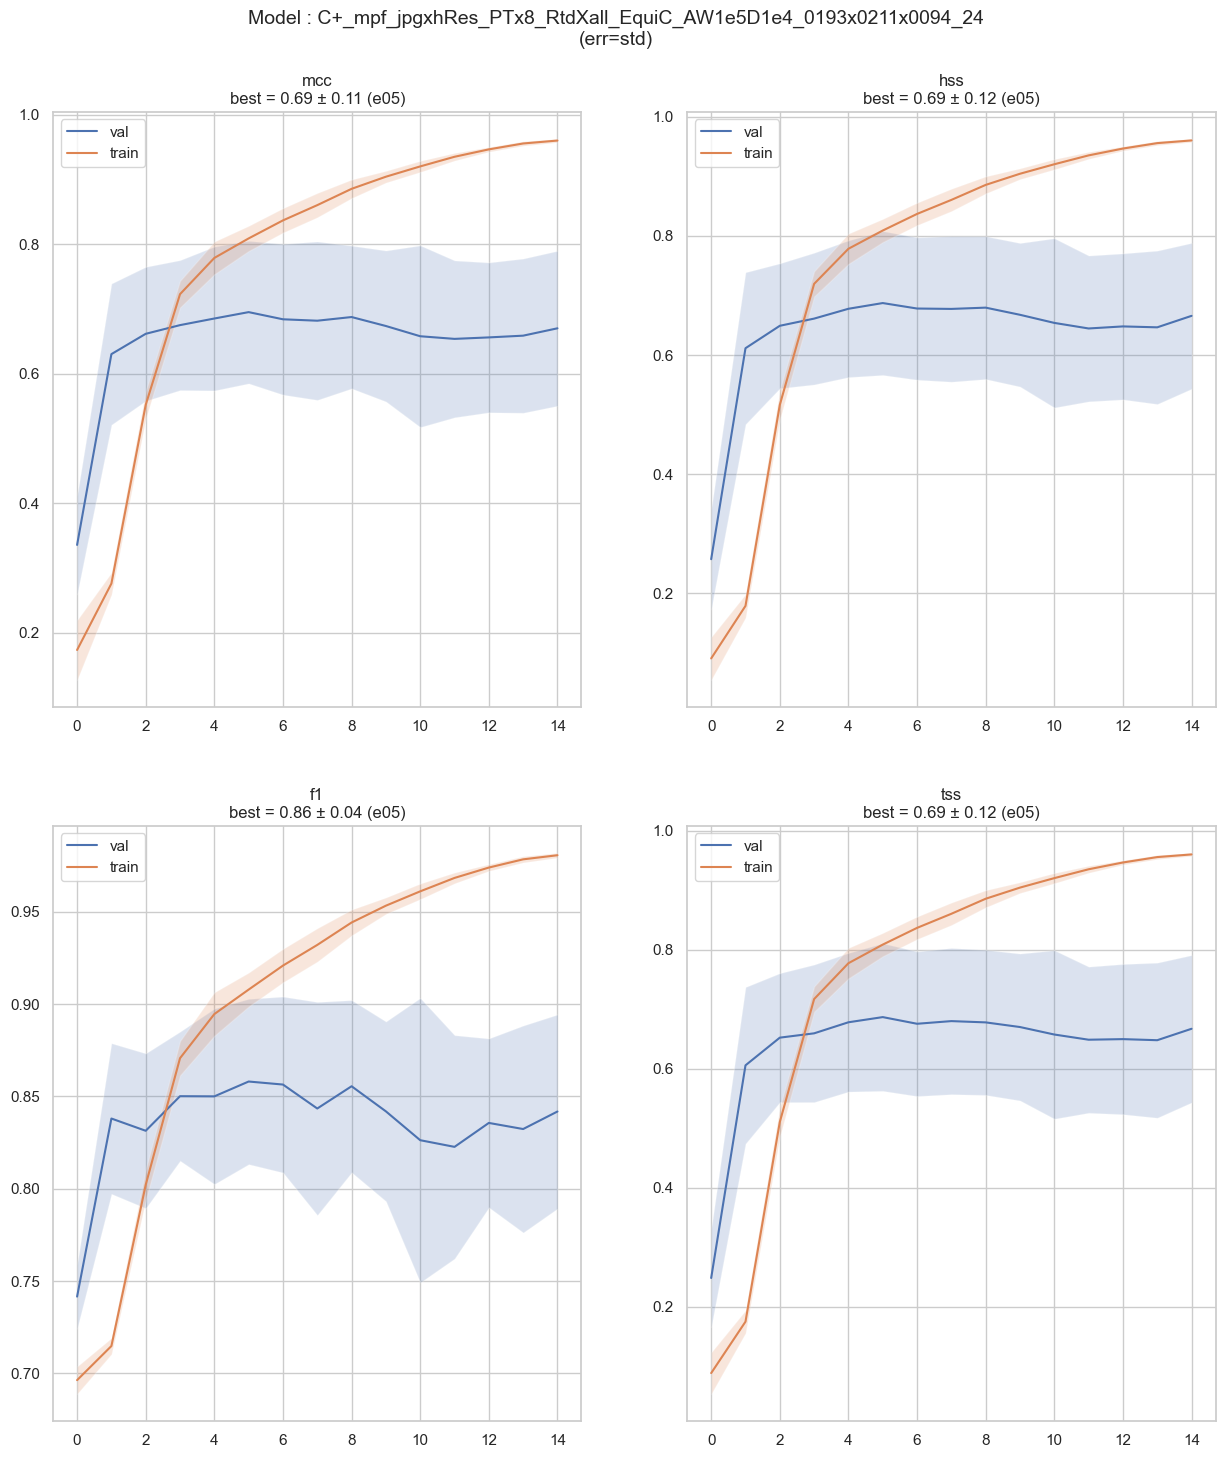

In [17]:
%%time

model =  'best'
# model = 'M+_mpf_PTx8_RtdXall_ProgPos_AW1e5D1e4_0193x0211x0094_24'
# model = 'M+_mpf_PTx8_RtdXall_LowC_AW6e6D1e3_blos_24'

err_type =  'std'# err_type # 'std' , 'minmax' (used for cv only)

plt.figure(figsize=(15, 17))

metrics = ['mcc'  ,'hss','f1', 'tss']
  

if model=='best': 
  model = best.sort_values(by=['val_tss'],ascending=False)['model'].iloc[1] # skiping persistent
num_metrics = len(metrics)
for i in range(num_metrics):
  mtc = metrics[i]
  ax = plt.subplot(int(np.ceil(np.sqrt(num_metrics))), int(np.round(np.sqrt(num_metrics))), i + 1)
  val = np.array(res[model]['val_'+mtc])
  if len(val[~np.isnan(val)])==0:
    print(f'WARNING : no data for {model} {metrics[i]}')
  else:
    train = np.array(res[model][mtc])
    for idx,curve in enumerate([val, train]):
      preffix = 'val_' if idx==0 else ''
      label   = 'val' if idx==0 else 'train'
      ax.plot(curve, label=label)
      if hasCV:
        if err_type == 'minmax': err_type = ('min','max')
        if type(err_type) in [tuple,list]:
          lower = np.array(res[model][preffix+mtc+'_'+err_type[0]])
          upper = np.array(res[model][preffix+mtc+'_'+err_type[1]])
          #lower = lower[~np.isnan(lower)]
          #upper = upper[~np.isnan(upper)]
        else:
          yerr=best[metrics[0]+'_'+err_type], best[metrics[1]+'_'+err_type]
          err = np.array(res[model][preffix+mtc+'_'+err_type])
          #err = err[~np.isnan(err)]
          lower = curve - err
          upper = curve + err
        ax.fill_between(
          range(len(curve)),
          lower,
          upper,
          alpha=0.2)
    val = val[~np.isnan(val)]
    if mtc in ['loss','far','mae','mse']:
      bestmtc = np.min(val)
      bestepc = int(np.argmin(val))
    else:
      bestmtc = np.max(val)
      bestepc = int(np.argmax(val))
    if hasCV:
      if err_type == 'minmax': err_type = ('min','max')
      if type(err_type) in [tuple,list]:
        low = res[model]['val_'+mtc+'_'+err_type[0]][bestepc]
        up  = res[model]['val_'+mtc+'_'+err_type[1]][bestepc]
        extratitle = f' <{low:.2f};{up:.2f}>'
      else:
        std = res[model]['val_'+mtc+'_'+err_type][bestepc]
        extratitle = f' ± {std:.2f}'
      extratitle += f' (e{bestepc:0>2})'
    else:
      extratitle = f' at epoch  {bestepc}'
    ax.set_title(f'{mtc}\nbest = {bestmtc:.2f}{extratitle}')
    ax.legend()
    #plt.axis("off")
extratitle = f'\n(err={str(err_type)})' if hasCV else ''
plt.suptitle(f'Model : {model}{extratitle}', y = 0.94, fontsize=14)